In [ ]:
import catalax as ctx

ctx.set_host_count(8)
import catalax.mcmc as cmc
import pyenzyme as pe

/Users/max/code/chromhandler-example/.venv/lib/python3.12/site-packages/catalax/dataset/dataset.py:1030: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
/Users/max/code/chromhandler-example/.venv/lib/python3.12/site-packages/catalax/dataset/dataset.py:1038: UserWarning: The figure layout has changed to tight
  plt.tight_layout(w_pad=4, h_pad=4)


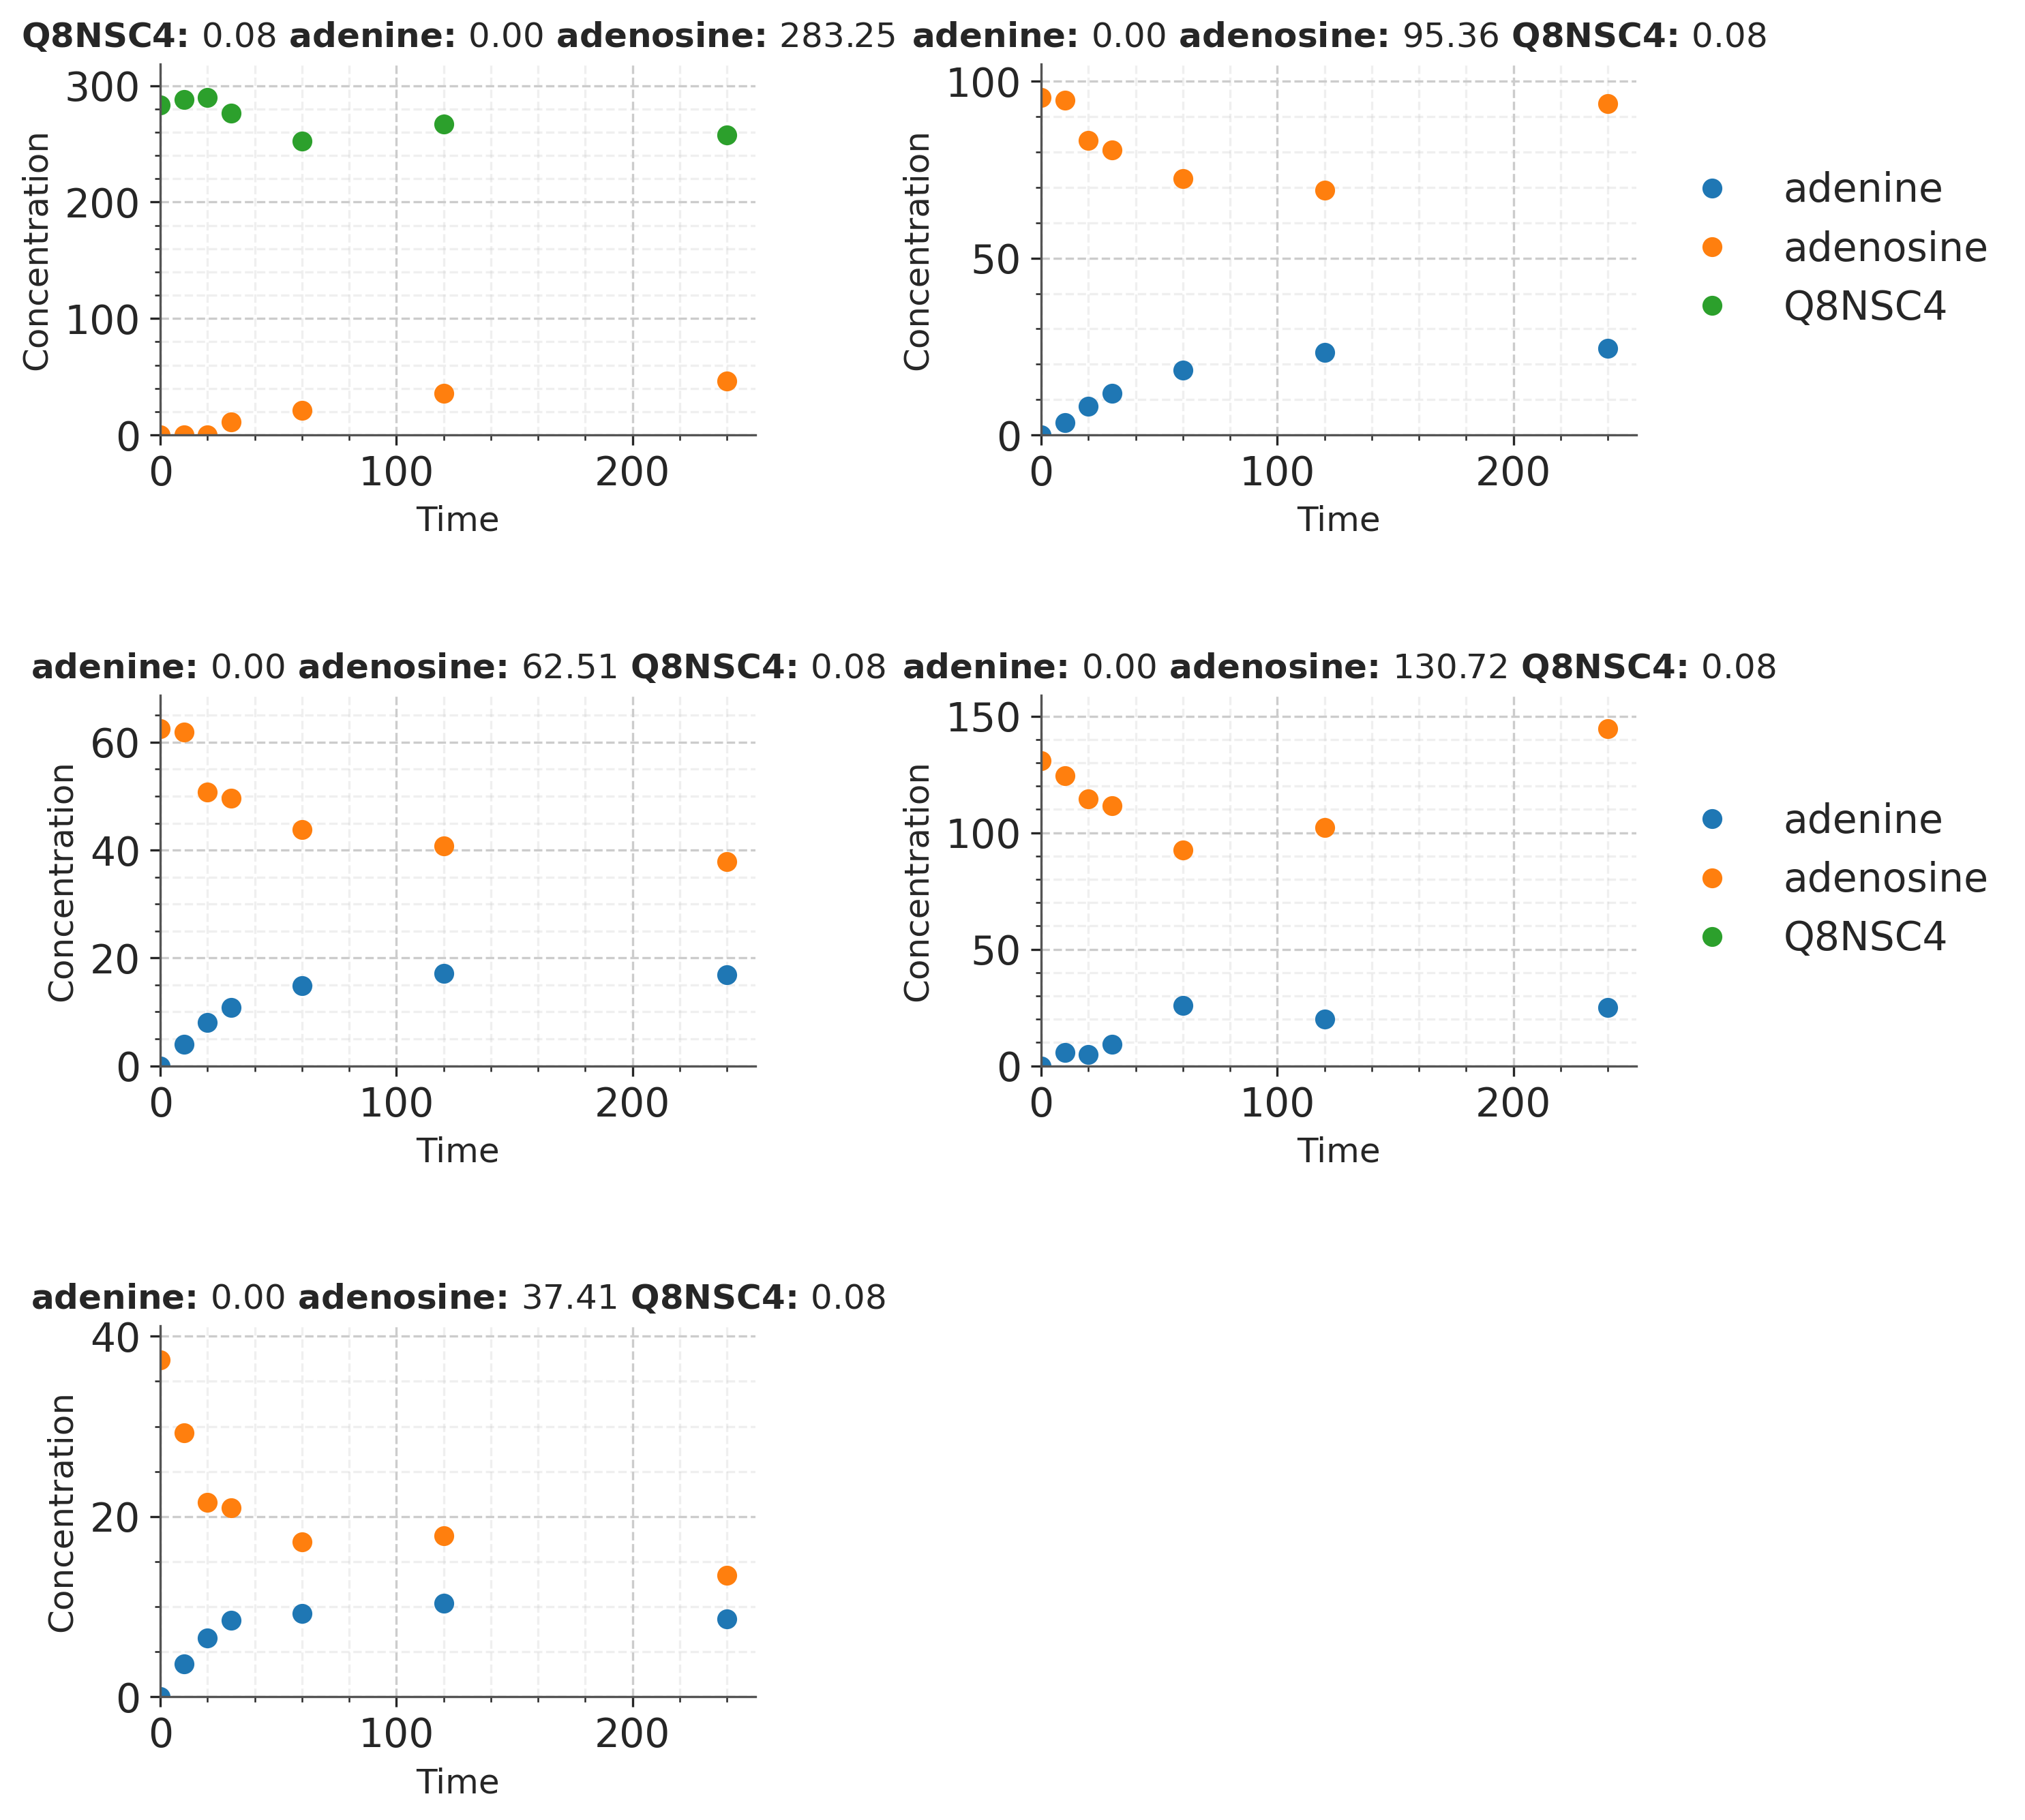

In [20]:
# read in enzymeml
doc = pe.read_enzymeml("data/enzymeml.json")
dataset = ctx.Dataset.from_enzymeml(doc)
dataset = dataset.pad()

dataset.plot(show=True)

In [21]:
ds, model = ctx.from_enzymeml(doc)

In [22]:
model

""


""


""


""


Model(name='kinetic', odes=DottedDict({}), species=, parameters=, constants=, assignments=)

In [23]:
dataset


Dataset(
    id='kinetic',
    species=['adenine', 'adenosine', 'Q8NSC4'],
    name='kinetic',
    description=None,
    measurements=[
        Measurement(
            id='CF6',
            name=None,
            description=None,
            initial_conditions={'Q8NSC4': 0.08125, 'adenine': 0.0, 'adenosine': 283.2477021635316},
            data={
                'adenine': Array([ 0.      ,  0.      ,  0.      , 11.220125, 21.360743, 35.87822 ,
       45.988262], dtype=float32),
                'adenosine': Array([283.2477 , 288.05124, 289.49286, 276.55902, 252.47876, 267.1852 ,
       257.5274 ], dtype=float32),
                'Q8NSC4': Array([nan, nan, nan, nan, nan, nan, nan], dtype=float32, weak_type=True)
            },
            time=Array([  0.,  10.,  20.,  30.,  60., 120., 240.], dtype=float32),
            species=['adenine', 'adenosine', 'Q8NSC4']
        ),
        Measurement(
            id='CF8',
            name=None,
            description=None,
            init

## Define model

In [24]:
model = ctx.Model(name="reversible MM")
model.add_species("Q8NSC4, adenine, adenosine")
model

KEQ = 1.3

model.add_ode(
    "adenine",
    "(( (vf/km_adenosine) * (adenosine - adenine/KEQ) ) / "
    "(1 + adenosine/km_adenosine + adenine/km_adenine))".replace("KEQ", str(KEQ)),
)
model.add_ode(
    "adenosine",
    "-(( (vf/km_adenosine) * (adenosine - adenine/KEQ) ) / "
    "(1 + adenosine/km_adenosine + adenine/km_adenine))".replace("KEQ", str(KEQ)),
)

model.add_ode(
    "Q8NSC4",
    "0",
)

model.parameters["vf"].prior = cmc.priors.LogUniform(low=0.01, high=1000)
model.parameters["km_adenosine"].prior = cmc.priors.LogUniform(low=0.01, high=1000)
model.parameters["km_adenine"].prior = cmc.priors.LogUniform(low=0.01, high=1000)

In [25]:
hmc = cmc.HMC(
    num_warmup=2000,
    num_samples=10000,
    dt0=0.1,
    max_steps=64**4,
    verbose=1,
    num_chains=8,
    chain_method="parallel",
)

results = hmc.run(model=model, dataset=dataset, yerrs=2.0)

# Apply the median posterior to the model
fitted_model = results.get_fitted_model()

# Print the summary
results.summary()



🚀 Running MCMC



  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
km_adenine,0.193,0.353,0.010,0.801,0.002,0.006,7769.0,3451.0,1.0
km_adenosine,19.773,77.915,0.016,73.166,1.087,4.181,8154.0,8204.0,1.0
sigma,4.931,0.503,4.000,5.958,0.003,0.002,32883.0,33241.0,1.0
vf,7.201,49.114,0.209,13.420,0.740,5.752,11674.0,4794.0,1.0


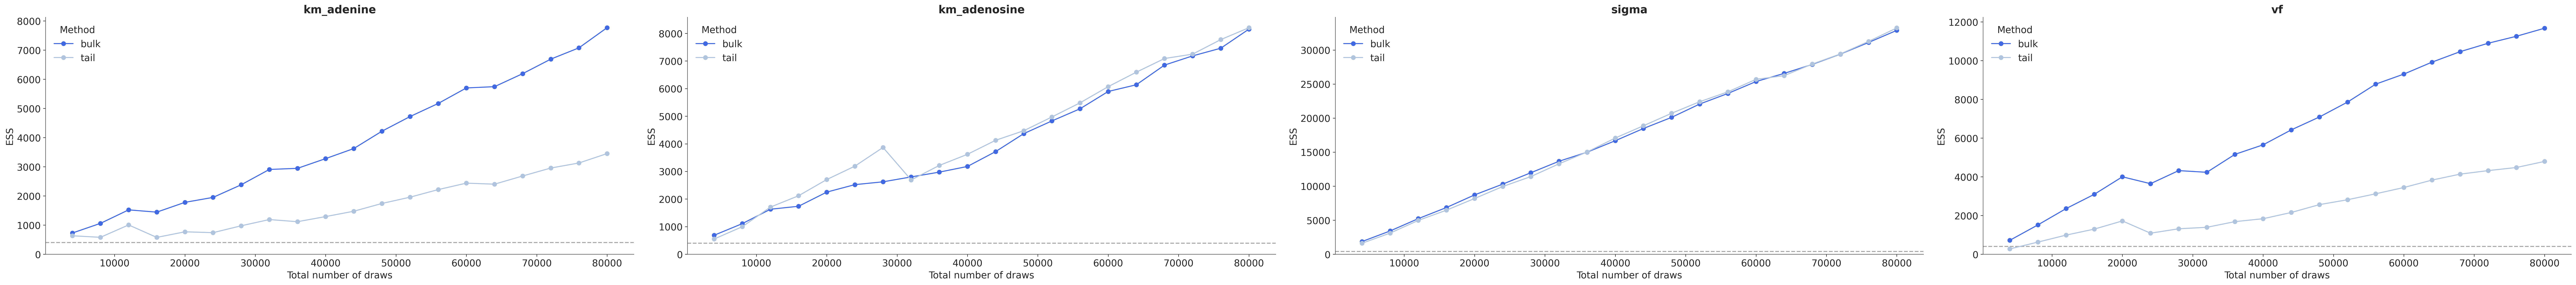

/Users/max/code/chromhandler-example/.venv/lib/python3.12/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/Users/max/code/chromhandler-example/.venv/lib/python3.12/site-packages/catalax/mcmc/plotting.py:56: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


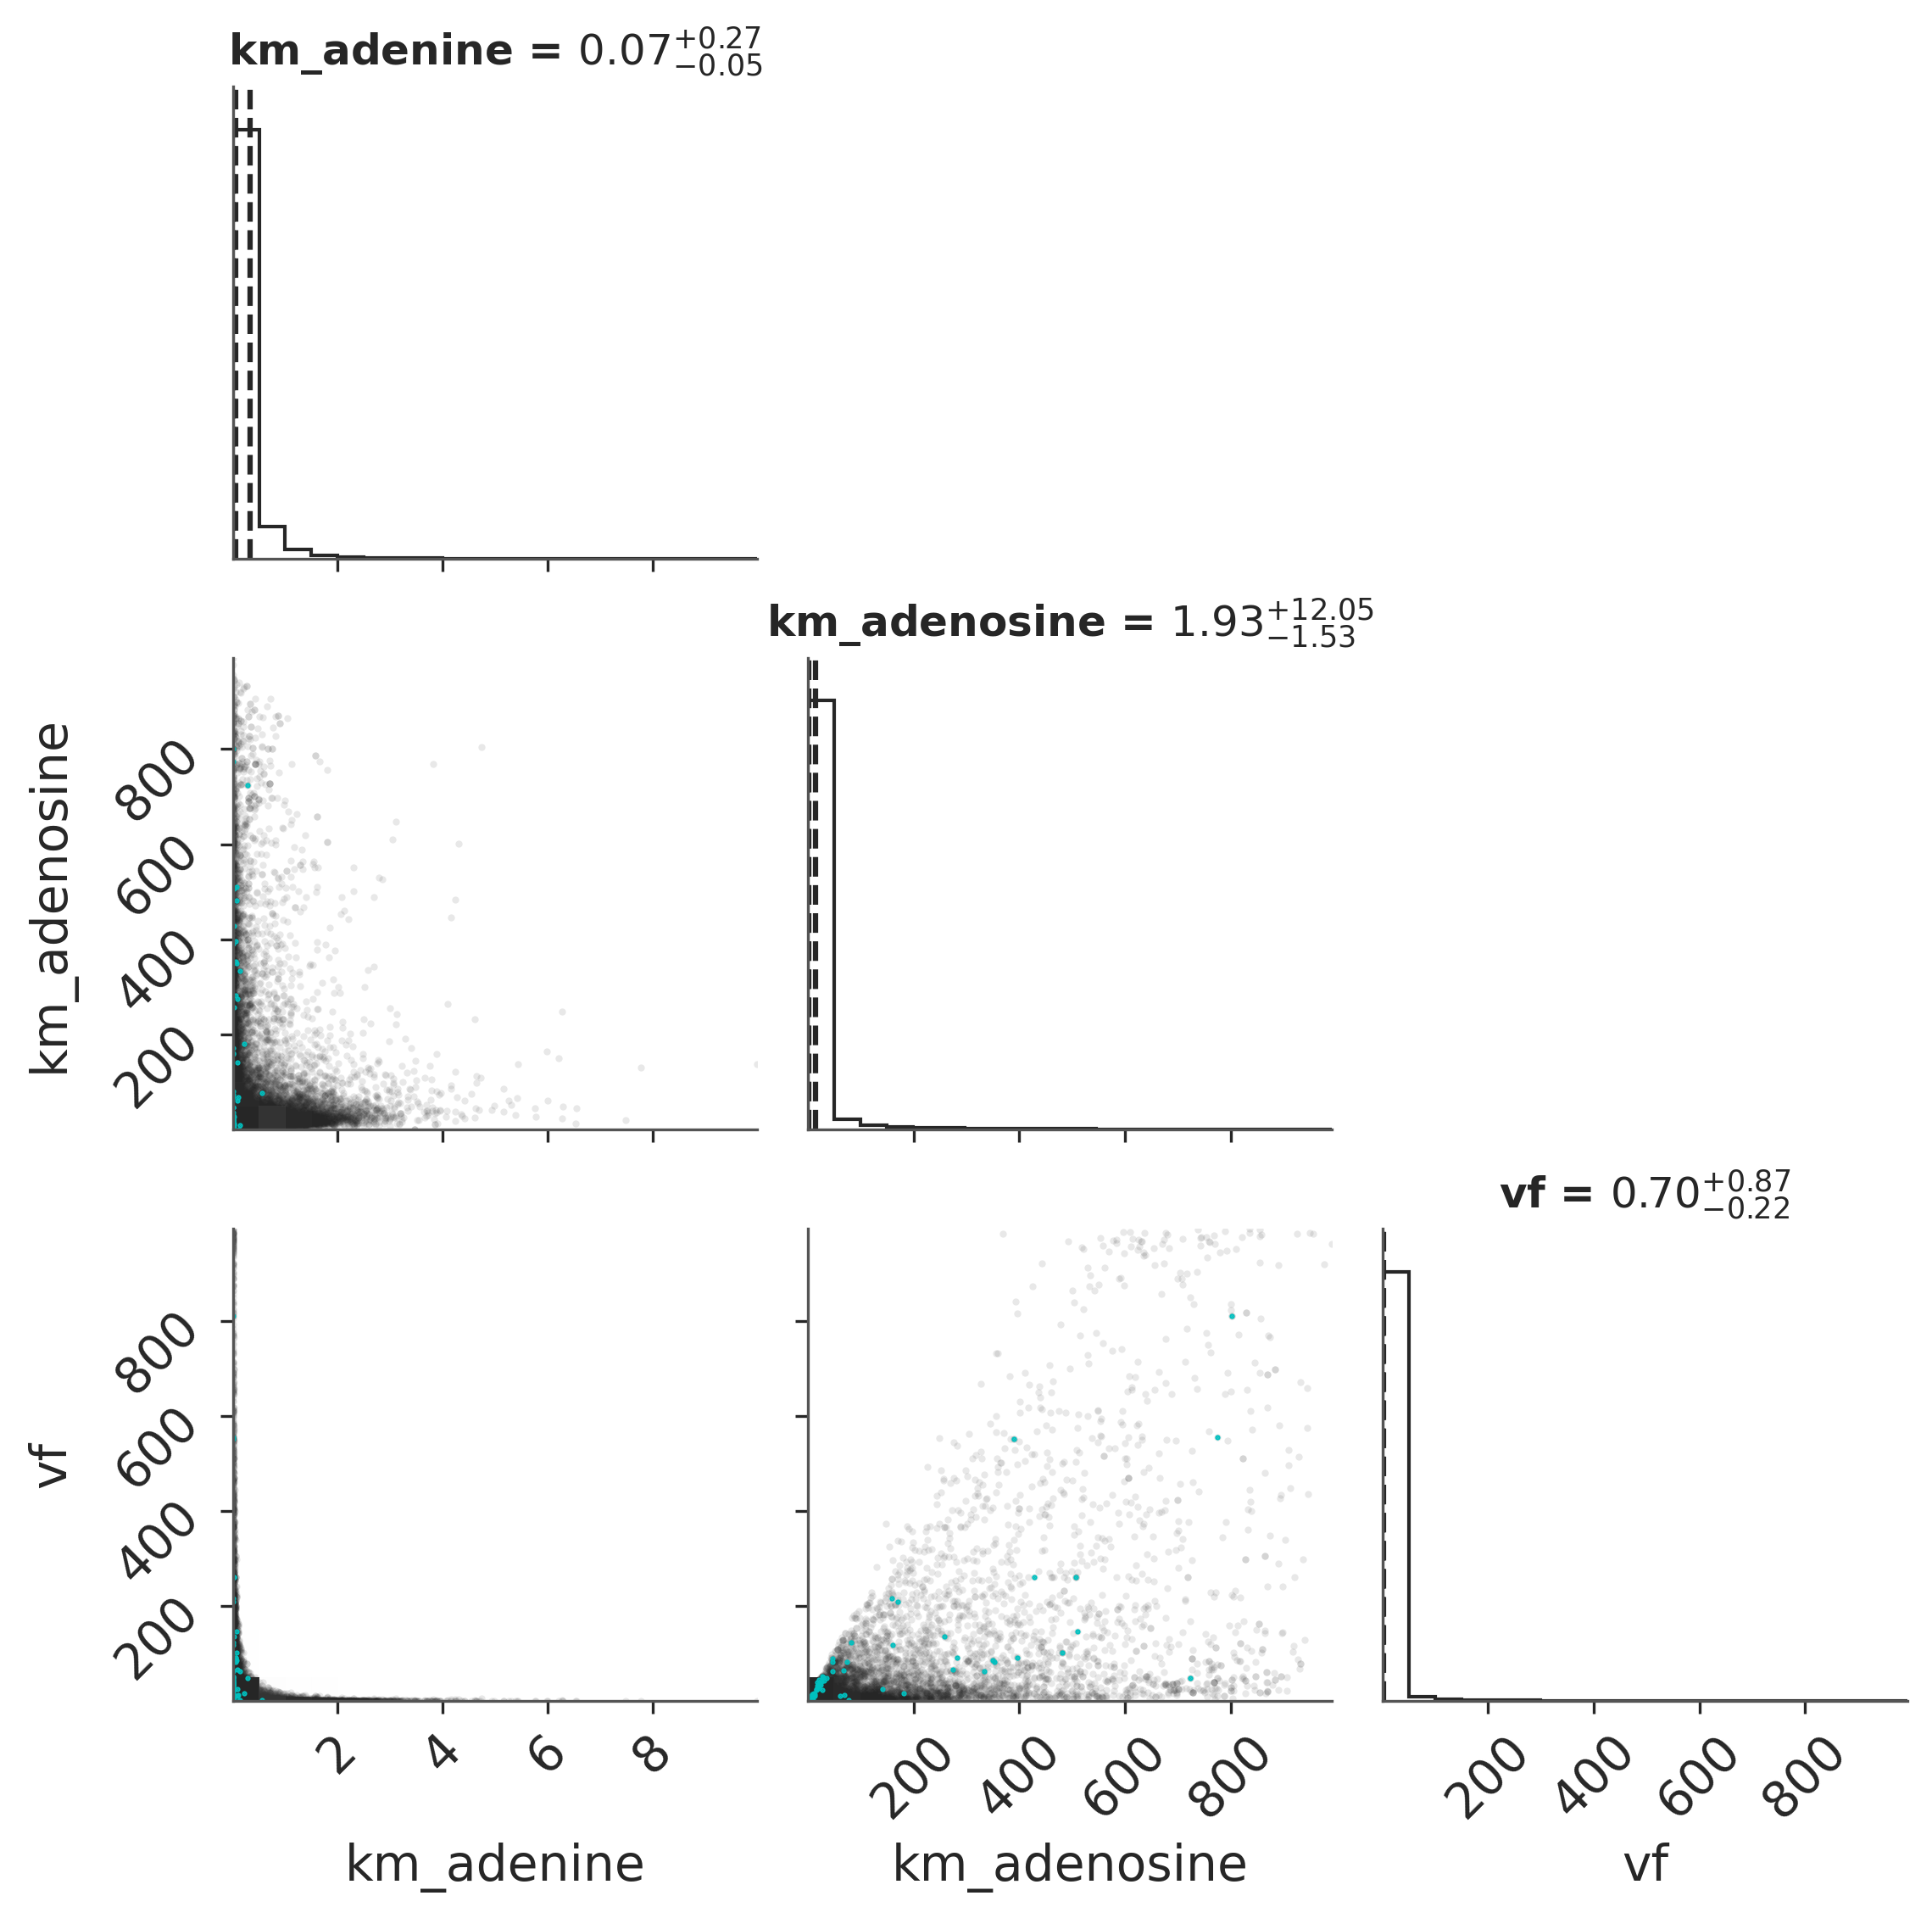

In [26]:
# Plot the trace
results.plot_ess(show=True)

# Plot the corner
results.plot_corner(show=True)


/Users/max/code/chromhandler-example/.venv/lib/python3.12/site-packages/catalax/dataset/dataset.py:1038: UserWarning: The figure layout has changed to tight
  plt.tight_layout(w_pad=4, h_pad=4)


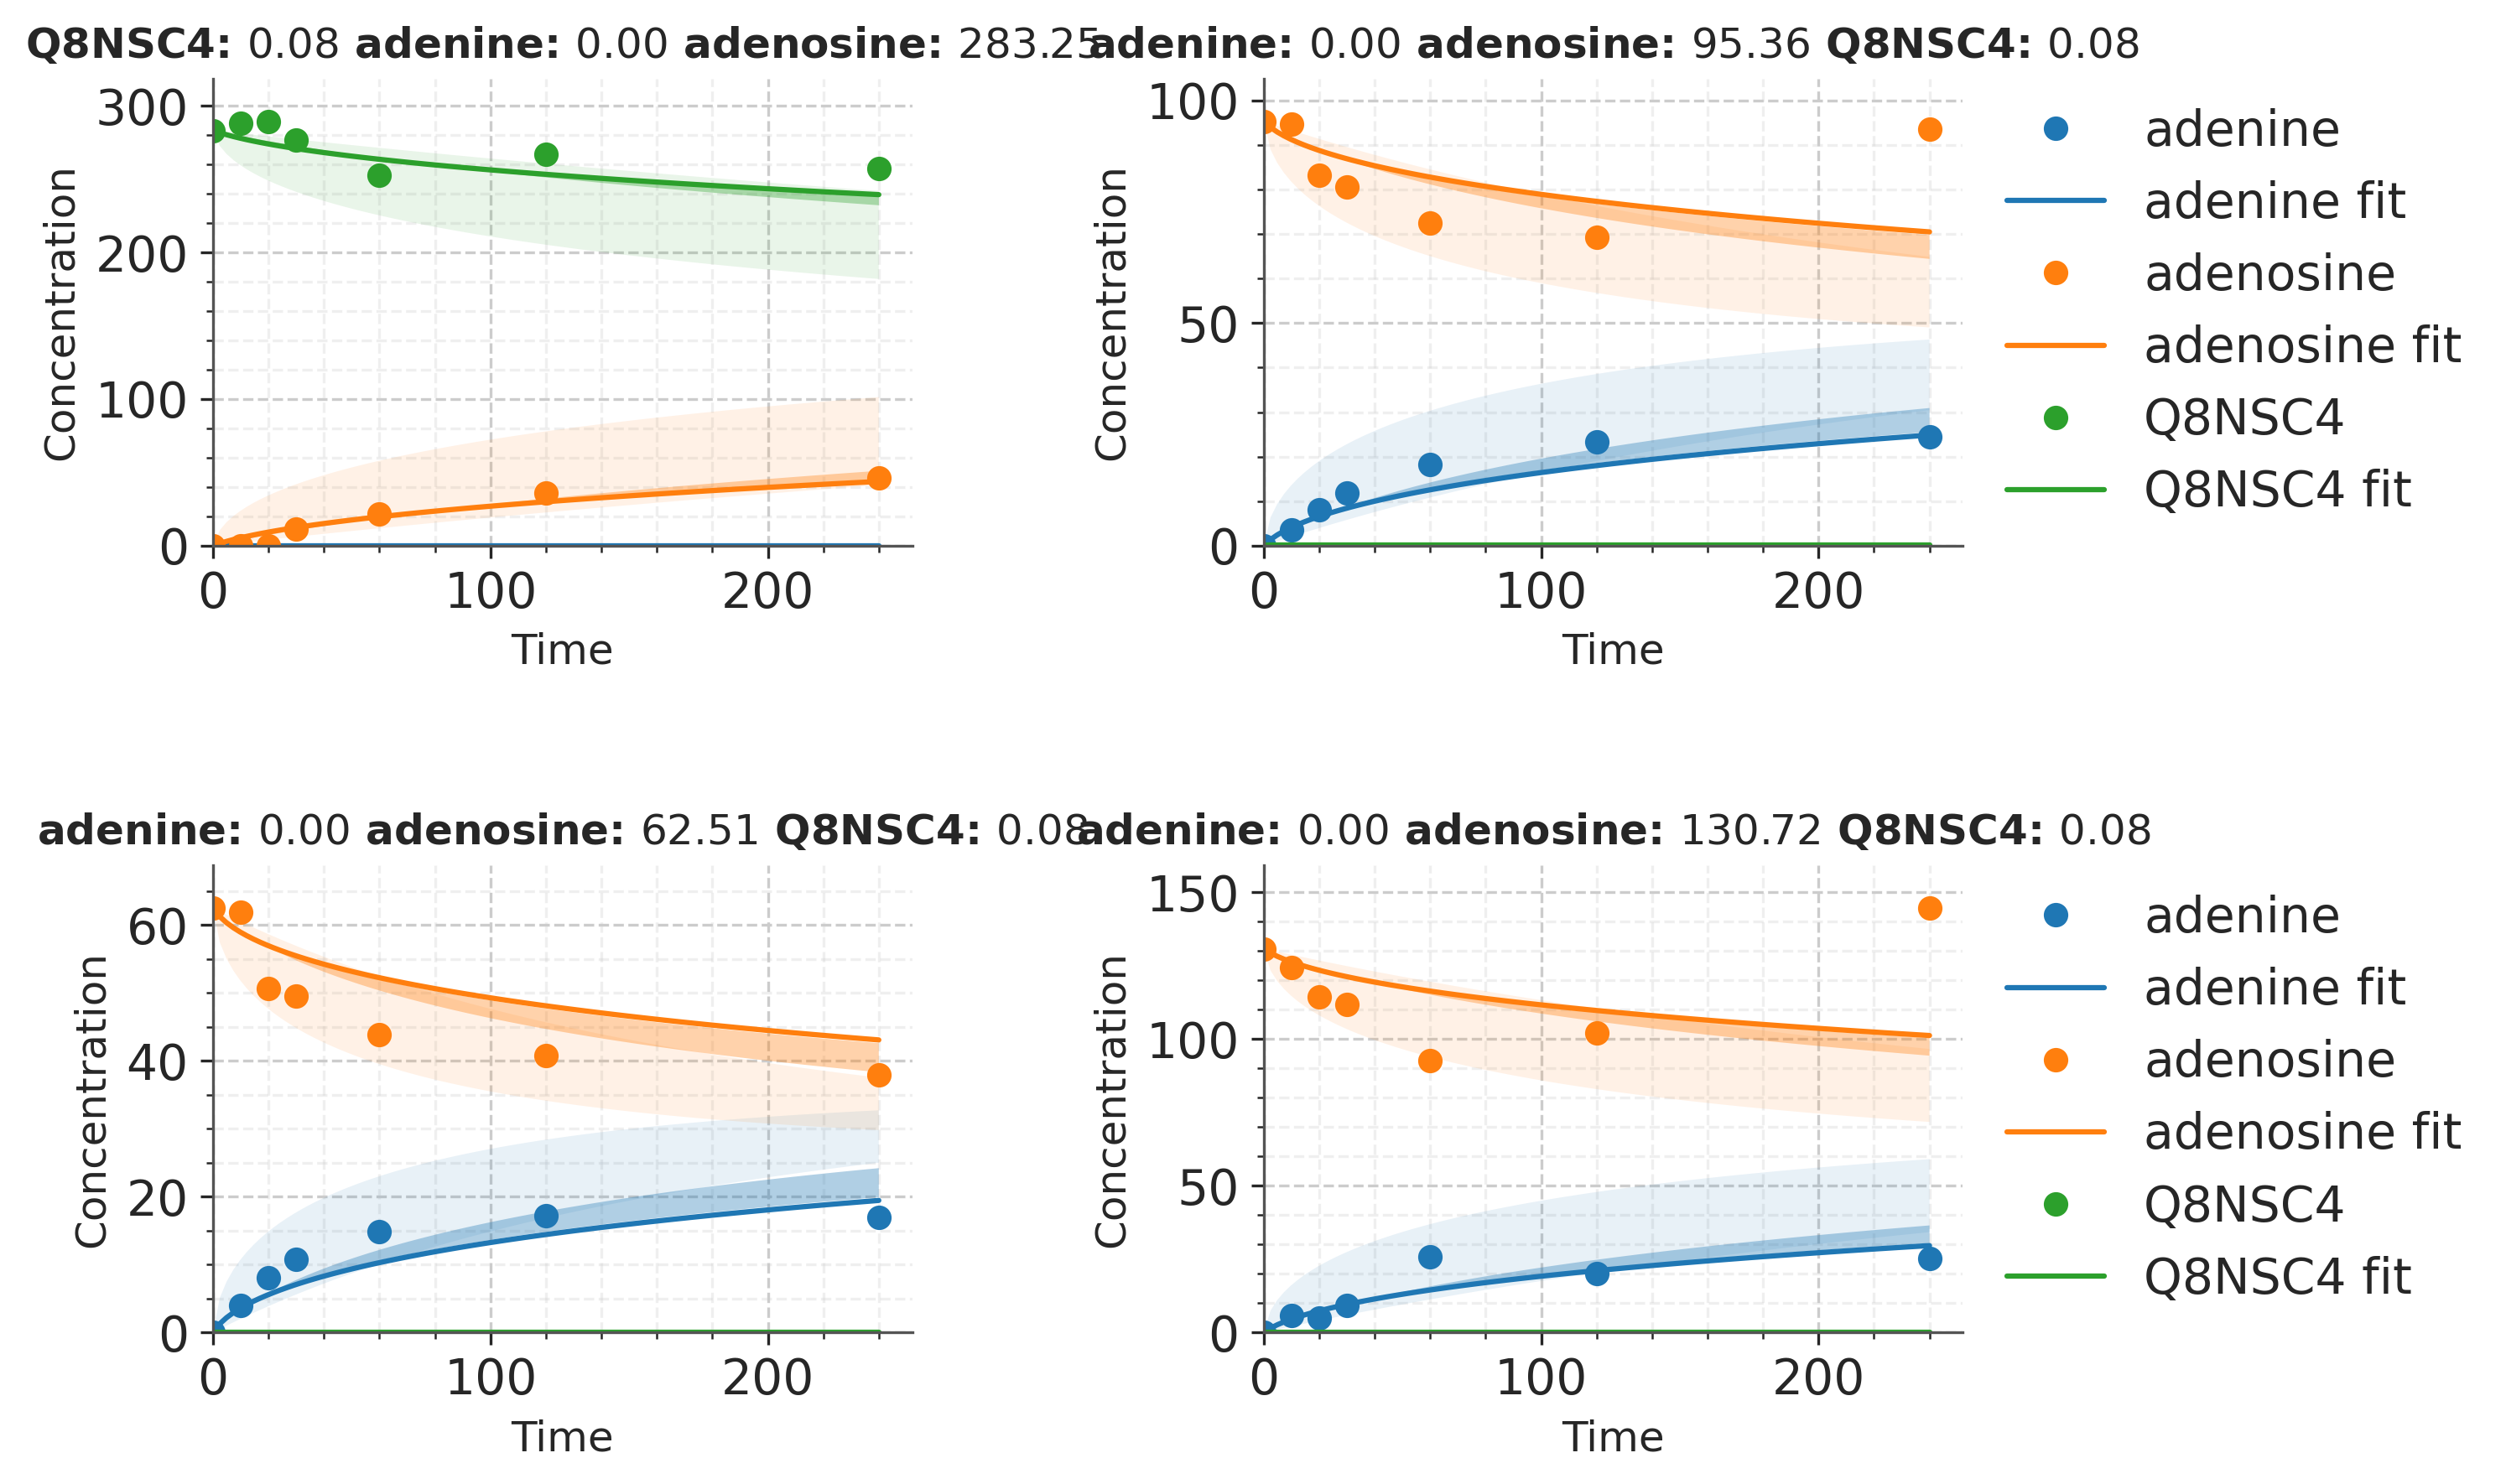

In [27]:
dataset.plot(
    predictor=fitted_model,
    measurement_ids=[m.id for m in dataset.measurements[:4]],
    show=True,
)
